In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # pip install matplotlib
from scipy import stats # pip install scipy

In [2]:
df = pd.read_csv("04_live_trading/trades.csv", encoding = "UTF-8")

df["time_difference"] = df["time_executed"] - df["time_expected"]

conditions = [
    df["side"] == "Buy"
    , df["side"] == "Sell"
]
choices = [
    - (df["price_executed"] / df["price_expected"] - 1)
    , df["price_executed"] / df["price_expected"] - 1
]

df["price_deviation"] = np.select(conditions, choices, default = None).astype("float64")
df["price_absolute_deviation"] = abs(df["price_deviation"])

df_btc = df[df["symbol"] == "BTCUSDT"]
df_sc = df[df["symbol"] == "SCUSDT"]

#### Descriptive statistics

In [3]:
df_btc[["time_difference", "price_deviation", "price_absolute_deviation"]].describe()

,time_difference,price_deviation,price_absolute_deviation
count,141.000000,141.000000,141.000000
mean,245.950355,-0.000024,0.000082
std,150.753172,0.000182,0.000164
min,82.000000,-0.001198,0.000000
25%,85.000000,-0.000003,0.000000
50%,382.000000,-0.000003,0.000003
75%,384.000000,0.000000,0.000102
max,423.000000,0.000428,0.001198


In [4]:
df_sc[["time_difference", "price_deviation", "price_absolute_deviation"]].describe()

,time_difference,price_deviation,price_absolute_deviation
count,188.000000,188.000000,188.000000
mean,269.308511,-0.001275,0.001569
std,147.167810,0.001550,0.001250
min,80.000000,-0.005497,0.000000
25%,85.000000,-0.002111,0.000509
50%,383.000000,-0.001207,0.001364
75%,385.000000,-0.000196,0.002129
max,438.000000,0.002838,0.005497


#### Scatter plot of expected and executed price, and price deviation and time difference

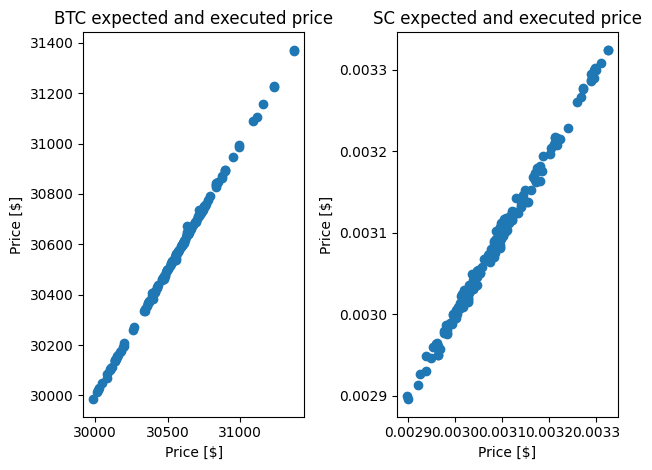

In [5]:
def draw_scatter_plot(position, df, title, first_column, second_column, xlabel, ylabel):
    plt.subplot(1, 2, position)
    plt.scatter(df[first_column], df[second_column])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

draw_scatter_plot(1, df_btc, "BTC expected and executed price", "price_expected", "price_executed", "Price [$]", "Price [$]")
draw_scatter_plot(2, df_sc, "SC expected and executed price", "price_expected", "price_executed", "Price [$]", "Price [$]")

plt.tight_layout()
plt.show()

We can identify a linear relationship between expected and executed price. However, SC has a little more deviation than BTC.

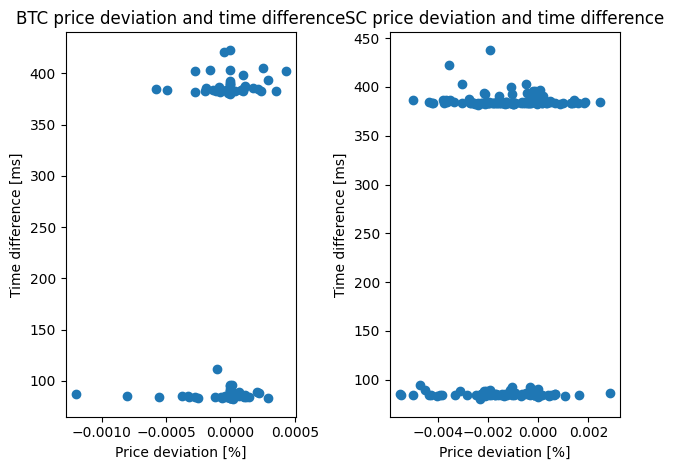

In [6]:
draw_scatter_plot(1, df_btc, "BTC price deviation and time difference", "price_deviation", "time_difference", "Price deviation [%]", "Time difference [ms]")
draw_scatter_plot(2, df_sc, "SC price deviation and time difference", "price_deviation", "time_difference", "Price deviation [%]", "Time difference [ms]")

plt.tight_layout()
plt.show()

The time differences can be grouped into two. These do not, however, seem to impact the price deviation that much.

#### Histogram of price deviation

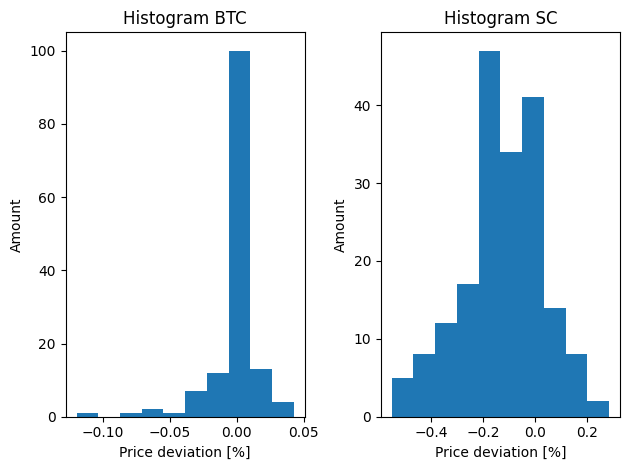

In [7]:
def draw_histogram(position, df, symbol):
    plt.subplot(1, 2, position)
    plt.hist(df["price_deviation"] * 100)
    plt.title(f"Histogram {symbol}")
    plt.xticks()
    plt.xlabel("Price deviation [%]")
    plt.ylabel("Amount")

draw_histogram(1, df_btc, "BTC")
draw_histogram(2, df_sc, "SC")

plt.tight_layout()
plt.show()

#### Statistical tests

In [8]:
def statistical_tests(df):
    _, p_shapiro_wilk = stats.shapiro(df["price_deviation"])
    _, p_kolmogorov_smirnov = stats.kstest(df["price_deviation"], "norm")
    _, p_wilcoxon = stats.wilcoxon(df["price_deviation"])

    print(f"p of Shapiro-Wilk test: {p_shapiro_wilk}.")
    print(f"p of Kolmogorov-Smirnov test: {p_kolmogorov_smirnov}.")
    print(f"p of Wilcoxon test: {p_wilcoxon}.")


In [9]:
statistical_tests(df_btc)

p of Shapiro-Wilk test: 1.6118303773354368e-16.
p of Kolmogorov-Smirnov test: 4.261598813985575e-33.
p of Wilcoxon test: 0.048378175826970266.


Null hypothesis rejected if p < 0.05.

**Null hypothesis for all tests rejected:**
<br>*Shapiro-Wilk & Kolmogorov-Smirnov* >> No normal distribution.
<br>*Wilcoxon* >> Significant difference between the actual and expected prices.

In [10]:
statistical_tests(df_sc)

p of Shapiro-Wilk test: 0.09243045747280121.
p of Kolmogorov-Smirnov test: 8.936437612217706e-44.
p of Wilcoxon test: 6.536908724213547e-20.


Null hypothesis rejected if p < 0.05.

**Null hypothesis for two tests rejected:**
<br>*Shapiro-Wilk* >> Test passed. This could indicate a normal distribution.
<br>*Kolmogorov-Smirnov* >> No normal distribution.
<br>*Wilcoxon* >> Significant difference between the actual and expected prices.